   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Training dataset size: 3006 examples
Validation dataset size: 52 examples
Total number of trainable parameters: 171,105,024


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,5.711400
2,4.420500
3,5.998000
4,4.575600
5,4.856900
6,3.923800
7,4.053100
8,3.882500
9,3.774700
10,3.866700


Streaming output truncated to the last 5000 lines.
Logs at step 2012: {'loss': 2.4737, 'grad_norm': 1.2077821493148804, 'learning_rate': 2.7700155245065422e-05, 'epoch': 1.338656021290752}
Captured loss: 2.4737 at step 2012
Logs at step 2013: {'loss': 2.657, 'grad_norm': 1.5322693586349487, 'learning_rate': 2.7689066311820806e-05, 'epoch': 1.3393213572854292}
Captured loss: 2.657 at step 2013
Logs at step 2014: {'loss': 2.6562, 'grad_norm': 1.316685676574707, 'learning_rate': 2.767797737857618e-05, 'epoch': 1.3399866932801063}
Captured loss: 2.6562 at step 2014
Logs at step 2015: {'loss': 2.6255, 'grad_norm': 1.3456860780715942, 'learning_rate': 2.766688844533156e-05, 'epoch': 1.3406520292747839}
Captured loss: 2.6255 at step 2015
Logs at step 2016: {'loss': 2.4739, 'grad_norm': 1.7118213176727295, 'learning_rate': 2.765579951208694e-05, 'epoch': 1.341317365269461}
Captured loss: 2.4739 at step 2016
Logs at step 2017: {'loss': 2.6528, 'grad_norm': 1.4005275964736938, 'learning_rate': 2

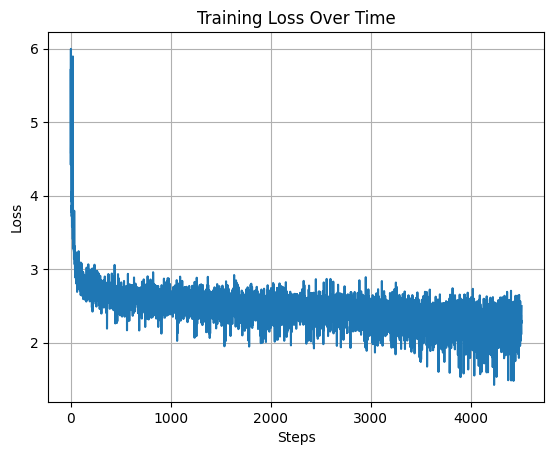

In [ ]:
!pip install transformers tokenizers datasets

from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling, TrainerCallback
from tokenizers import ByteLevelBPETokenizer
import torch
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive for persistent storage
drive.mount('/content/drive')

# Set up training directory
training_dir = "/content/drive/MyDrive/gpt2_training"
os.makedirs(training_dir, exist_ok=True)
os.chdir(training_dir)

# File path for the dataset
file_path = "/content/pastic_basic_filter.txt"  # Adjust based on upload location
fallback_text = "This is a sample text to count tokens. It contains multiple sentences."

# Step 1: Train or load the tokenizer
def train_or_load_tokenizer(data_path, vocab_size=50257):  # Standard GPT-2 vocab size
    tokenizer_dir = "tokenizer"
    # Force retraining by checking for a specific flag or removing existing tokenizer
    if not os.path.exists(os.path.join(tokenizer_dir, "vocab.json")) or os.path.getsize(os.path.join(tokenizer_dir, "vocab.json")) == 0:
        print(f"Training tokenizer on: {data_path}")
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Training file not found: {data_path}. Please upload the dataset file or adjust the file_path.")
        tokenizer = ByteLevelBPETokenizer()
        tokenizer.train(files=[data_path], vocab_size=vocab_size, min_frequency=2, special_tokens=[
            "<s>", "<pad>", "</s>", "<unk>", "<mask>"
        ])
        os.makedirs(tokenizer_dir, exist_ok=True)
        tokenizer.save_model(tokenizer_dir)
        print("Tokenizer trained and saved.")
    else:
        tokenizer = ByteLevelBPETokenizer.from_file(
            os.path.join(tokenizer_dir, "vocab.json"),
            os.path.join(tokenizer_dir, "merges.txt")
        )
        print("Tokenizer loaded from existing files.")
    return tokenizer

# Train or load the ByteLevelBPETokenizer
if not os.path.exists(file_path):
    print(f"Dataset file not found: {file_path}. Creating a temporary file with fallback text.")
    temp_file = "temp_fallback.txt"
    with open(temp_file, "w", encoding="utf-8") as f:
        f.write(fallback_text)
    bpe_tokenizer = train_or_load_tokenizer(temp_file, vocab_size=1000)  # Smaller vocab for fallback
    os.remove(temp_file)  # Clean up temporary file
else:
    bpe_tokenizer = train_or_load_tokenizer(file_path)

# Step 2: Count tokens in the file
def count_tokens(tokenizer, input_text):
    encoded = tokenizer.encode(input_text)
    return len(encoded.ids), encoded.tokens

def count_tokens_in_file(tokenizer, file_path):
    total_tokens = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        while True:
            chunk = f.read(1024 * 1024)  # Read 1MB at a time
            if not chunk:
                break
            token_count, _ = count_tokens(tokenizer, chunk)
            total_tokens += token_count
    return total_tokens

# Verify file and count tokens
if os.path.exists(file_path):
    print(f"File size: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        preview_text = f.read(1000)  # Read first 1000 chars for preview
        print(f"First 100 characters: {preview_text[:100]}...")
    total_tokens = count_tokens_in_file(bpe_tokenizer, file_path)
    print(f"Total number of tokens: {total_tokens}")
else:
    print(f"File not found: {file_path}. Using fallback text.")
    token_count, tokens = count_tokens(bpe_tokenizer, fallback_text)
    print(f"Total number of tokens (using fallback text): {token_count}")
    print(f"Tokens: {tokens[:10]}...")
    # Continue with fallback text for tokenization but warn about limited training
    with open("temp_fallback.txt", "w", encoding="utf-8") as f:
        f.write(fallback_text)
    file_path = "temp_fallback.txt"

# Step 3: Load tokenizer for GPT-2 training
tokenizer = GPT2TokenizerFast.from_pretrained("tokenizer")
tokenizer.pad_token = "<pad>"
tokenizer.bos_token = "<s>"
tokenizer.eos_token = "</s>"

# Step 4: Dataset preparation with train-validation split
def load_and_split_dataset(file_path, tokenizer, block_size=1024, val_ratio=0.1):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset file not found: {file_path}. Please upload the dataset file.")
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    train_lines, val_lines = train_test_split(lines, test_size=val_ratio)
    with open("train.txt", "w", encoding='utf-8') as f:
        f.writelines(train_lines)
    with open("valid.txt", "w", encoding='utf-8') as f:
        f.writelines(val_lines)
    train_dataset = TextDataset(tokenizer=tokenizer, file_path="train.txt", block_size=block_size)
    val_dataset = TextDataset(tokenizer=tokenizer, file_path="valid.txt", block_size=block_size)
    return train_dataset, val_dataset

# Load dataset
train_dataset, val_dataset = load_and_split_dataset(file_path, tokenizer)
print(f"Training dataset size: {len(train_dataset)} examples")
print(f"Validation dataset size: {len(val_dataset)} examples")

# Step 5: Data Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Step 6: Model Configuration and Initialization
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=1024,
    n_ctx=1024,
    n_embd=768,  # Increased from 768 to 1024
    n_layer=24,   # Increased from 14 to 24
    n_head=16,    # Increased from 12 to 16
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)
model = GPT2LMHeadModel(config)

# Print the number of parameters in the model
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {total_params:,}")
    return total_params

count_parameters(model)

# Step 7: Custom callback to collect losses
class LossLogger(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        print(f"Logs at step {state.global_step}: {logs}")
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)
            print(f"Captured loss: {logs['loss']} at step {state.global_step}")

loss_logger = LossLogger()

# Step 8: Training Configuration
training_args = TrainingArguments(
    output_dir="gpt2-from-scratch",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=1,
    logging_dir="logs",
    report_to=["tensorboard"],
    do_eval=True,
    eval_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[loss_logger]
)

# Step 9: Train and Save
try:
    trainer.train()
except Exception as e:
    print(f"Training failed with error: {e}")

model.save_pretrained("gpt2-from-scratch")
tokenizer.save_pretrained("gpt2-from-scratch")
print("✅ Training complete. Model and tokenizer saved.")

# Step 10: Plot training loss
print(f"Steps: {loss_logger.steps}")
print(f"Losses: {loss_logger.losses}")
if len(loss_logger.steps) == 0 or len(loss_logger.losses) == 0:
    print("No loss data captured. Check logging configuration or dataset size.")
else:
    plt.plot(loss_logger.steps, loss_logger.losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.savefig('training_loss.png')  # Save plot instead of showing

# Clean up temporary file if created
if os.path.exists("temp_fallback.txt"):
    os.remove("temp_fallback.txt")